# Определение успешности компьютерных игр

<div class="alert alert-block alert-info">  
Имеются данные о продажах игр (а также оценки пользователей и экспертов, жанры и платформы) до 2016 года. Необходимо выявить закономерности, определяющие успешность игры, которые позволят сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
    
<br> Для выполнения задачи:
1. Откроем имеющиеся датафреймы и изучим общую информацию в них
2. Приведем данные к правильнум типам (где это потребуется)
3. Заполним, где необходимо, пропуски
4. Удалим дубликаты (если они есть)
5. Добавим необходимые столбцы (общие продажи)
6. Определим актуальный период и возьмем соответствующие ему данные. Для этого:
- Посмотрим на распределение игр по годам;
- Посмотрим, как менялись продажи по платформам.
7. Посмотрим на динамику продаж по платформам и определим потенциально прибыльные платформы.    
8. Проанализируем влияние оценок пользователей и критиков на продажи.  
9. Определим наиболее прибыльные жанры игр.
10. Составим портрет пользователя каждого региона. Определим:
- Популярные платформы и жанры;
- Влияние рейтинга
11. Проверим необходимые гипотезы
</div>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
None

Defaulting to user installation because normal site-packages is not writeable


### Шаг 1. Загрузка данных

In [3]:
games = pd.read_csv('games.csv')

In [4]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Шаг 2. Предобработка данных

1. Изменим названия столбцов

In [5]:
games.columns = games.columns.str.lower()

In [6]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В данных есть пропуски (name, genre, year_of_release, critic_score, user_score, rating). 
- Пропуски в названии и жанре можно оставить, так как для исследования они нам не важны. (Скорее всего появились случайно, в ходе заполнения данных). 
- Пропуски в отзывах пользователей, критиков и рейтинге хоть и важны, но заполнить их самостоятельно мы не сможем, поэтому тоже оставим. (Пропуски могли появиться из-за того, что на некоторые игры, не пользующиеся популярностью, отзывы не собирали, как и на игры, выпушенные более 20 лет назад; данные о рейтинге могли оставить пустыми, например, из-за того, что игра старая, а раньше определять рейтинг для игр было необязательно).
- Данные о годе выпуска важны для дальнейшего анализа, однако заменить пропуски мы не сможем, поэтому удалим строки с пропусками в столбце year_of_release (менее 2% от всех данных). (Скорее всего пропуски появились случайно, в ходе заполнения данных). 

2. Удалим данные с пропусками в годе выпуска

In [7]:
games = games.dropna(subset=['year_of_release'])
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


3. Преобразуем тип данных

In [8]:
games['year_of_release'] = games['year_of_release'].astype(int)

В столбце user_score есть значения - 'tbd'. Данная аббревиатура означает, что оценка еще не определена, но будет определена в дальнейшем. Для нашего исследования это значение можно заменить на NaN.

In [9]:
games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

4. Проверим, что дубликатов нет

In [10]:
games.duplicated().sum() # Дубликатов нет

0

5. Добавим суммарные продажи

In [11]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

<div class="alert alert-block alert-info">
<b>В ходе предобработки данных были выявлены некоторые проблемы:</b>
    
* Названия столбцов содержат заглавные буквы: для удобства дальнейшего исследования мы привели их к нижнему регистру.
* В данных есть пропуски: некоторые из них мы решили оставить, а данные с пропущенным годом выпуска удалили.
* Тип данных в year_of_release и user_score был неправильно определен, поэтому мы привели его к нужному типу.
* Столбец user_score помимо числовых значений имел значения 'tbd', которые мы решили заменить на NaN.
* Также мы добавили столбец суммарных продаж - 'total_sales' 
</div>

### Шаг 3. Исследовательский анализ данных

1. Построим гистограмму количества выпущенных игр по годам

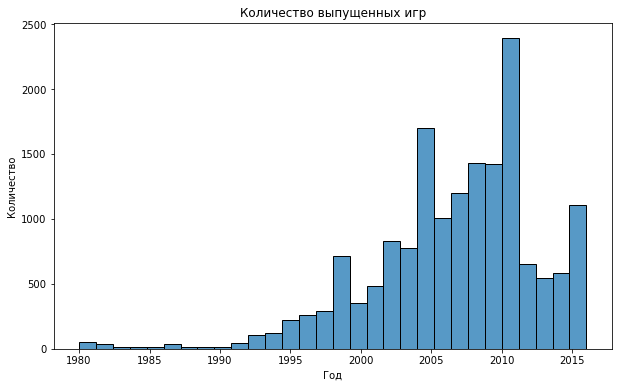

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(data=games, x="year_of_release", bins=30)
plt.title("Количество выпущенных игр")
plt.xlabel("Год")
plt.ylabel("Количество")
plt.show()

<div class="alert alert-block alert-info">
До 1995 года выпускалось достаточно мало игр (меньше 200), следовательно данные за этот период скорее всего нам не понадобятся.
  
Также мы видим, что после 2000 года спрос на компьютерные игры сильно вырос, а в 2010 начал снижаться. Такую динамику можно объяснить тем, что в 00-х годах началось быстрое развитие рынка видеоигр, появлялись новые игровые платформы, которые предлагали все более разнообразные и интересные игры. Однако в 10-х годах количество выпускаемых игр начало падать, так как на рынке уже существовало достаточно различных видеоигр, а также постепенно начали набирать популярность мобильные игр.
</div>

2. Построим график для платформ и их суммарных продаж

In [13]:
platforms = games.pivot_table(values='total_sales', index='platform', aggfunc='sum')
platforms = platforms.sort_values(by='total_sales', ascending=False)

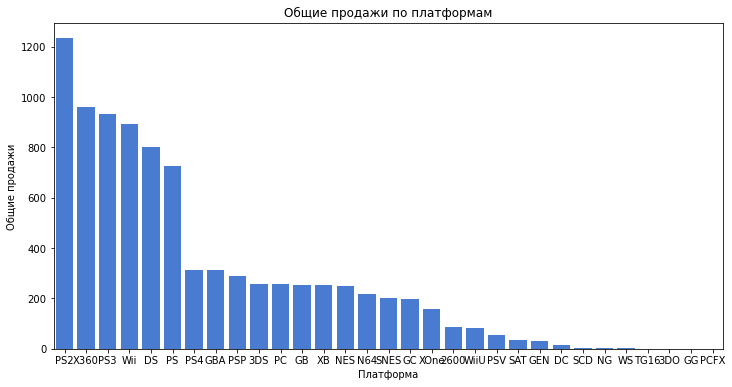

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(x=platforms.index, y='total_sales', data=platforms, color='#3277e6')
plt.title("Общие продажи по платформам")
plt.xlabel("Платформа")
plt.ylabel("Общие продажи")
plt.show()

<div class="alert alert-block alert-info">
Наиболее высокие продажи наблюдаются среди платформ: PS2, X360, PS3, Wii, DS, PS. 

In [15]:
games[(games['platform'] == 'DS') & (games['year_of_release'] < 2004)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN,0.02


<div class="alert alert-block alert-info">
Так как данные о продажах на платформе DS начинаются с 2004 года, за исключением одного наблюдения 1985 года, (в который к тому же было продано всего 0.02 миллиона), будем считать это значение аномальным и удалим его из наших данных. (После чего построим новый график).
</div>

In [16]:
games = games.drop(games[(games['platform'] == 'DS') & (games['year_of_release'] == 1985)].index)

3. Построим графики для 6 наиболее популярных платформ

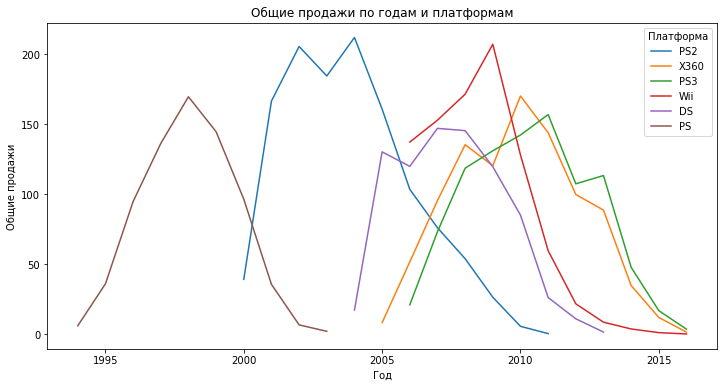

In [17]:
platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
platform_data = games[games['platform'].isin(platforms)]

grouped_data = platform_data.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

plt.figure(figsize=(12, 6))

for platform in platforms:
    platform_sales = grouped_data[grouped_data['platform'] == platform]
    sns.lineplot(x=platform_sales['year_of_release'], y=platform_sales['total_sales'], label=platform)

plt.title('Общие продажи по годам и платформам')
plt.xlabel('Год')
plt.ylabel('Общие продажи')
plt.legend(title='Платформа')
plt.show()

<div class="alert alert-block alert-info">
В среднем за 4 года платформа набирает популярность, а за последующие 4 года постепенно теряет ее. 
    
<br>В качестве актуального периода для дальнейшего анализа возьмем последние 4 года: 2013-2016 года.

In [18]:
# Возьмем данные за нужный период
new_games = games[games['year_of_release'] > 2012]

4. Построим графики для визуального отображения продаж по платформам

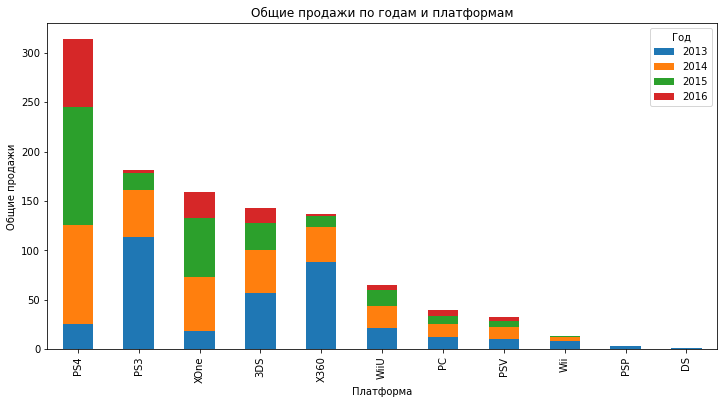

In [19]:
pivot_table = new_games.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum', fill_value=0)
pivot_table['total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='total', ascending=False)

pivot_table = pivot_table[[2013, 2014, 2015, 2016]]

plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca())

plt.title('Общие продажи по годам и платформам')
plt.xlabel('Платформа')
plt.ylabel('Общие продажи')
plt.legend(title='Год')
plt.show()

<div class="alert alert-block alert-info">
За рассматриваемый период динамика продаж игр фиксируется на 11 различных платформах.
    
<br>1) Сильнее всего выделяются платформы PS4 и XOne, которые только начали набирать популярность в 2013 году и к началу 2015 года достигли пика, а затем немного упали в продажах. При этом продажи PS4 на протяжении всего периода оставались значительно выше продаж XOne (начиная с 2014 года больше чем в 2 раза).
    
2) В 2013 году на платформах X360 и PS3 наблюдались самые большие продажи, однако к концу периода их количество резко упало.
    
3) Такие платформы как Wii, PSV, PC, WiiU уже в 2013 году имели низкие продажи и в течение 3 лет еще сильнее снизились.
    
4) Продажи на платформе DS и PSP представлены только за 2013 год, при этом они очень низкие.

<br>Таким образом, потенциально прибыльными платформами являются, в первую очередь, PS4, а также XOne.
<br> Кроме того, из-за низких объемов продаж, исключим из последующего анализа платформы DS и PSP.


5. Построим boxplot по продажам для каждой платформы

In [20]:
# Удалим данные по платформам DS и PSP
new_games = new_games[(new_games['platform'] != 'DS') & (new_games['platform'] != 'PSP')]

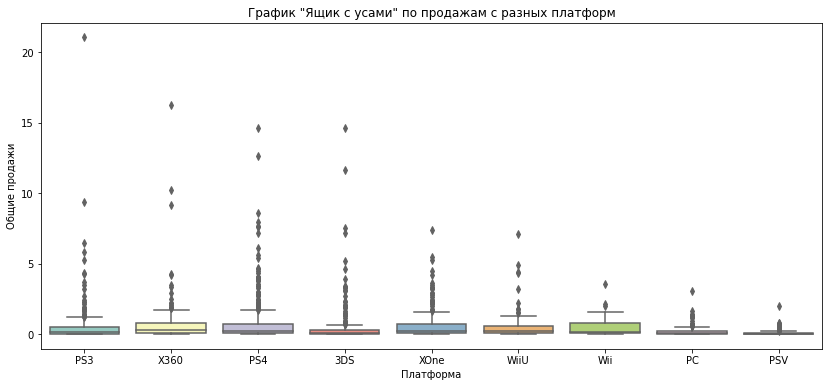

In [21]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=new_games, x='platform', y='total_sales', palette='Set3')

plt.title('График "Ящик с усами" по продажам с разных платформ')
plt.xlabel('Платформа')
plt.ylabel('Общие продажи')
plt.show()

<div class="alert alert-block alert-info"> Все платформы имеют незначительные выбросы в продажах, а такие платформы, как PS3, X360, PS4, 3DS, XOne, WiiU имееют также сильные выбросы: продажи в более чем 5 млн. Все распределения смешены к нижней границе (минимуму). Наиболешее медианное значение имеет платформа X360 (0.265), а наименьшее - PSV (0.04). Минимальные продажи среди всех платформ равны 0.01, а максимальные (исключая выбросы) у платформы Wii (2.01).

6. Далее рассмотрим наиболее популярную платформу PS4, чтобы посмотреть как влияют на продажи отзывы пользователей и критиков.

Посмотрим на корреляцию отзывов и продаж

In [22]:
# Напишем функцию для анализа корреляции
def correlation(platform):
    new_games_platform = new_games[(new_games['platform'] == platform) & 
                                   (new_games['user_score'].notna()) & 
                                   (new_games['critic_score'].notna())]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(data=new_games_platform, x='user_score', y='total_sales')
    plt.title('Зависимость от оценки пользователей')
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Общие продажи')

    plt.subplot(1, 2, 2)
    sns.scatterplot(data=new_games_platform, x='critic_score', y='total_sales', color='red')
    plt.title('Зависимость от оценки критиков')
    plt.xlabel('Оценка критиков')
    plt.ylabel('Общие продажи')

    plt.suptitle(f'Зависимость продаж на платформе {platform} от оценок')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()

    correlation = new_games_platform[['user_score', 'critic_score', 'total_sales']].corr()
    display(correlation)

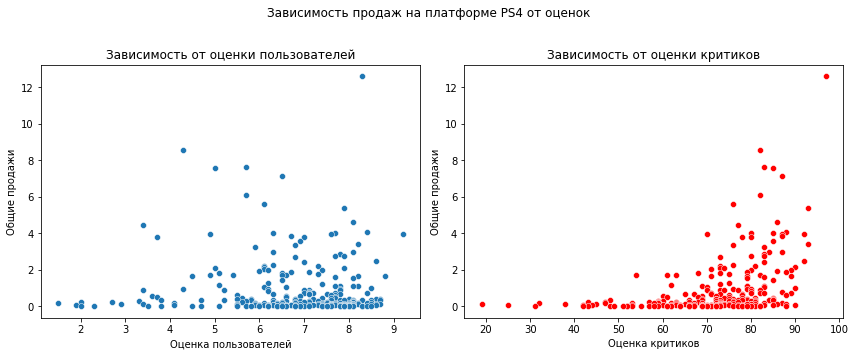

,user_score,critic_score,total_sales
user_score,1.000000,0.557654,-0.033625
critic_score,0.557654,1.000000,0.405895
total_sales,-0.033625,0.405895,1.000000


In [23]:
correlation('PS4')

<div class="alert alert-block alert-info">  
    
* Коэффициент корреляции между оценками критиков и продажами равен 0.4. Это говорит о том, что между этими показателями существует слабая положительная связь: чем выше оценка, тем больше продажи. Эту зависимость также можно проследить на графике
* Между оценками пользователей и продажами корреляция -0.03, значит оценка пользователей практически не влияет на сумму продаж.
    
Посмотрим так же еще несколько популярных платформ.
</div>  

7. Посмотрим корреляцию XOne, X360, PS3

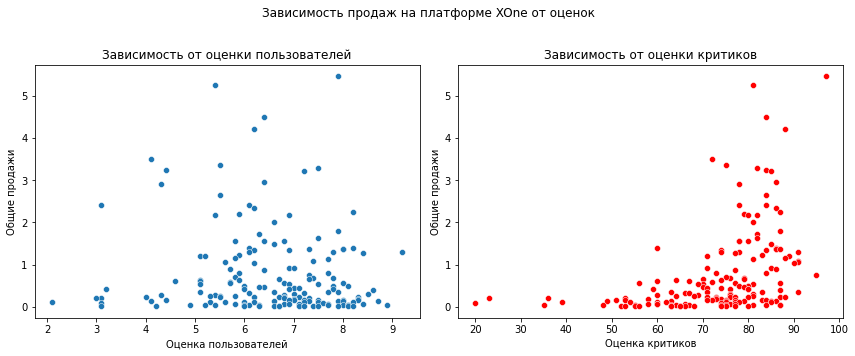

,user_score,critic_score,total_sales
user_score,1.000000,0.472462,-0.094003
critic_score,0.472462,1.000000,0.410422
total_sales,-0.094003,0.410422,1.000000


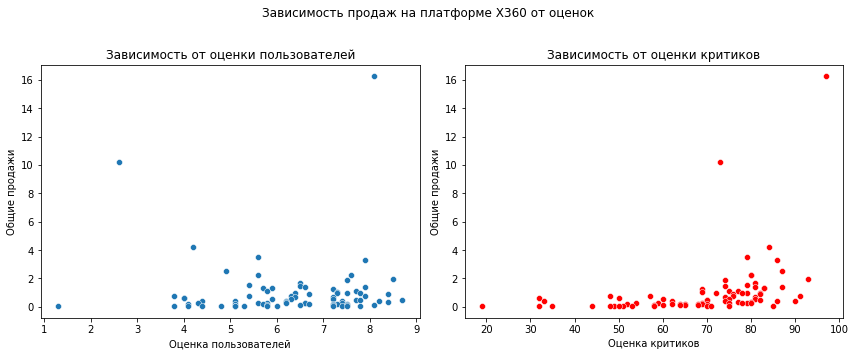

,user_score,critic_score,total_sales
user_score,1.000000,0.520946,-0.006238
critic_score,0.520946,1.000000,0.350345
total_sales,-0.006238,0.350345,1.000000


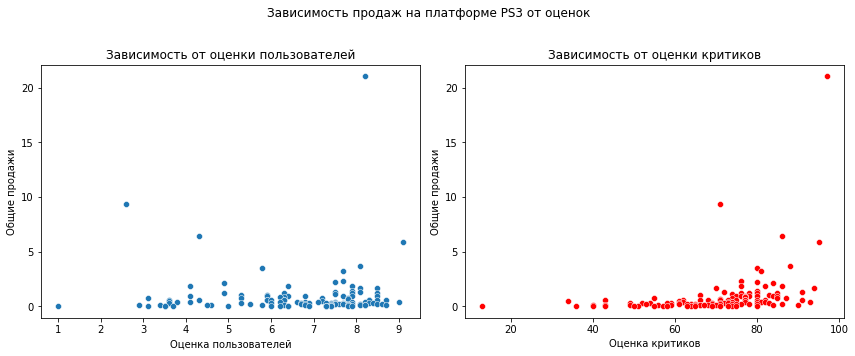

,user_score,critic_score,total_sales
user_score,1.000000,0.599920,0.022691
critic_score,0.599920,1.000000,0.333807
total_sales,0.022691,0.333807,1.000000


In [24]:
correlation('XOne')
correlation('X360')
correlation('PS3')

<div class="alert alert-block alert-info">  
Также посмотрев на корреляцию отзывов и продаж по другим популярным платформам, можно заметить, что зависимость практически не меняется.
</div>

8. Построим график распределения игр по жанрам

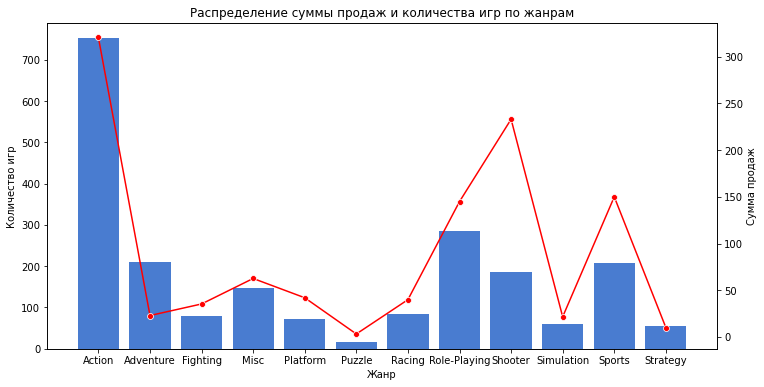

In [25]:
# Создадим сводную таблицу количества игр и суммы продаж по жанрам
genres = pd.pivot_table(new_games, values=['total_sales'], index='genre', aggfunc={'count', 'sum'})
genres.columns = ['count', 'total_sales']

# Построим график распределения игр по жанрам
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x=genres.index, y=genres['count'], ax=ax1, color='#3277e6')
ax1.set_xlabel('Жанр')
ax1.set_ylabel('Количество игр')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
sns.lineplot(x=genres.index, y=genres['total_sales'], ax=ax2, color='r', marker='o')
ax2.set_ylabel('Сумма продаж')
ax2.tick_params(axis='y')

plt.title('Распределение суммы продаж и количества игр по жанрам')

plt.show()

<div class="alert alert-block alert-info">  Наиболее прибыльными являются игры в жанре action: их выпускают чаще остальных, и их суммарные продажи также самые высокие. Жанр shooter тоже можно отнести к прибыльным: несмотря на то, что количество игр в этом жанре не так велико, по сумме продаж жанр занимает второе место. Также можно выделить жанры sports и role-playing, которые тоже имеют высокие продажи.
    
<br> Наименьшей популярностью пользуются игры жанров puzzle, strategy и simulation (они имеют наиболее низкие продажи).

9. Построим график медианных продаж по жанру

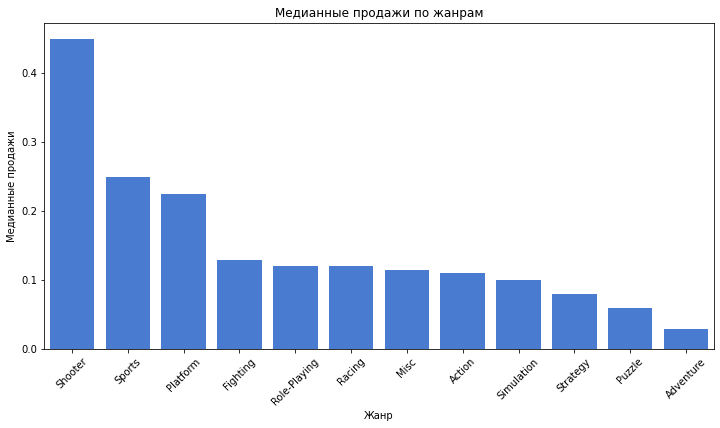

In [26]:
median_sales_by_genre = new_games.groupby('genre')['total_sales'].median().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=median_sales_by_genre.index, y=median_sales_by_genre.values, color='#3277e6')

plt.title('Медианные продажи по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Медианные продажи')

plt.xticks(rotation=45)
plt.show()

<div class="alert alert-block alert-info">  
Посмотрев на медианные продажи, можно сделать вывод, что наиболее стабильным и прибыльным является жанр Shooter. Sports и Platform также занимают высокие позиции. Наименьшие продажи наблюдаются среди игр жанров Adventure и Puzzle.
    
<br>Сравнивая с предыдушими выводами, стоит отметить, что хоть Action игры и имеют самые высокие суммарные продажи за рассматриваемый период, не все игры этого жанра стабильно приносят высокий доход (также по соотношению количества выпущенных игр и продажам можно предположить, что высокие продажи достигаются за счет большого количества игр, в отличие от жанра Shooter, где продажи высоки, а выпущенных игр намного меньше).
</div>

### Шаг 4. Составим портрет пользователя каждого региона

In [27]:
def top_5_charts(values_column, title):
    platform_pivot = pd.pivot_table(new_games, values=values_column, index='platform', aggfunc='sum')
    top_platforms = platform_pivot.nlargest(5, values_column)
    
    genre_pivot = pd.pivot_table(new_games, values=values_column, index='genre', aggfunc='sum')
    top_genres = genre_pivot.nlargest(5, values_column)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.barplot(x=top_platforms.index, y=top_platforms[values_column], ax=axes[0], color='#3277e6')
    axes[0].set_title('Топ 5 платформ')
    axes[0].set_xlabel('Платформа')
    axes[0].set_ylabel('Сумма продаж')

    sns.barplot(x=top_genres.index, y=top_genres[values_column], ax=axes[1], color='#f51111')
    axes[1].set_title('Топ 5 жанров')
    axes[1].set_xlabel('Жанр')
    axes[1].set_ylabel('Сумма продаж')

    fig.suptitle(f'Топ 5 популярных платформ и жанров игр среди пользователей {title}')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

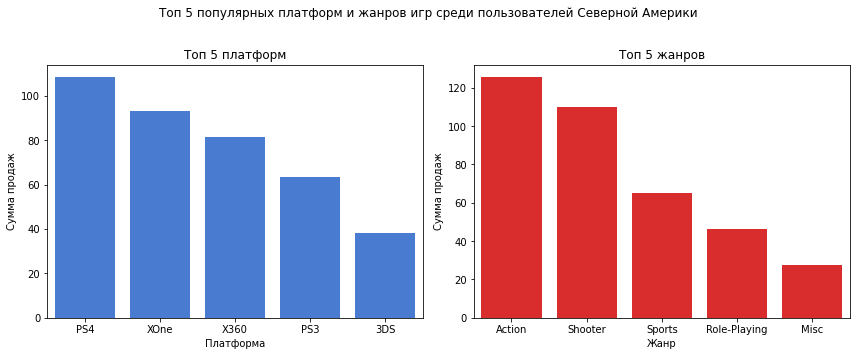

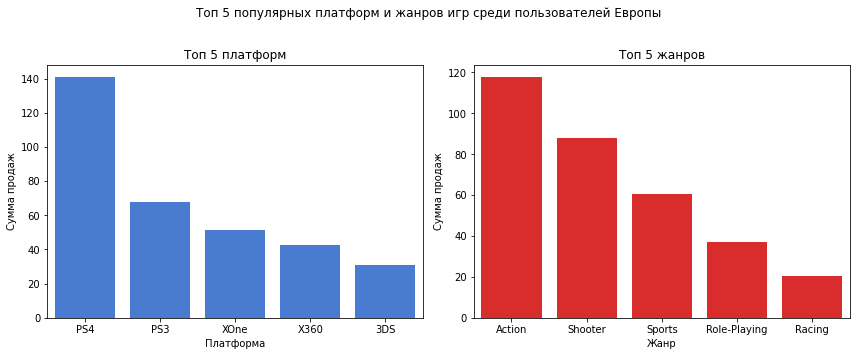

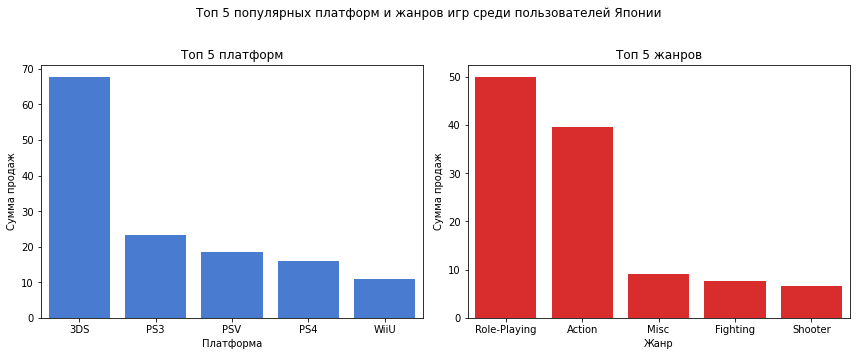

In [28]:
# Применим функцию для пользователей NA, EU, JP
top_5_charts('na_sales', 'Северной Америки')
top_5_charts('eu_sales', 'Европы')
top_5_charts('jp_sales', 'Японии')

<div class="alert alert-block alert-info">  
1) Для начала сравним популярные платформы для пользователей разных регионов. 
    
В США и Европе самыми продаваемыми играми являются игры на платформе PS4, в то время как в Японии наиболее популярна платформа 3DS. Это может быть связано с тем, что 3DS изначально сильно распространилась именно в Японии, к тому же производителем является японская компания, которая в большей степени была направлена на местную аудиторию. Также среди пользователей США можно наблюдать большую вариативность в выборе платформ. Это может быть объяснено тем, что рынок видеоигр в Америке очень разнообразен и конкурентоспособен, из-за чего пользователи, имея большой выбор игр на разных платформах, не склонны оьдавать предпочтение лишь одной.
    
<br> 2) Далее рассмотрим популярные жанры. 
    
Предпочитаемые жанры в Северной Америке и Европе почти одинаковы: это, в первую очередь, Action, а также Shooter и Sports. В Японии наиболее популярен жанр Role-playing, хотя Action также занимает высокое положение, стоя на втором месте. Предпочтения в жанрах отражают культуру и традиции стран: в Северной Америке и Европе вкусы игроков отражают склонность к динамичным и конкурентным играм, что может быть связано с активной спортивной культурой; в Японии же игроки предпочитают увлекательные и глубокие сюжеты, а также взаимодействия с персонажами.

In [29]:
# Заполним пропуски в столбце rating
new_games['rating'] = new_games['rating'].fillna('Не указано')

Посмотрим на продажи по рейтингу в разных регионах

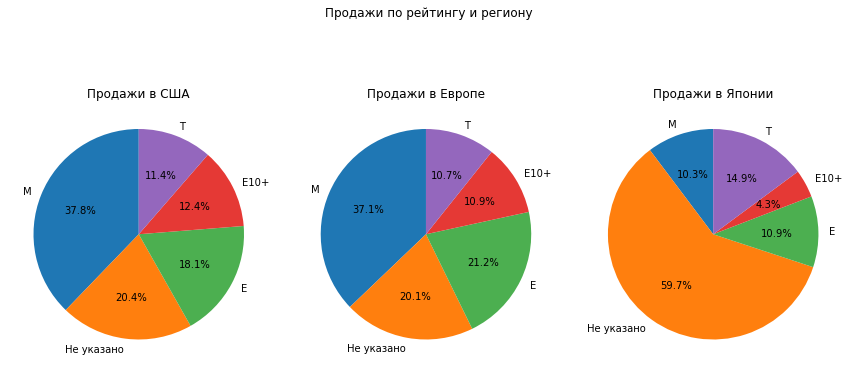

In [30]:
sales_by_rating = new_games.groupby('rating').agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum'}).reset_index()
sales_by_rating = sales_by_rating.sort_values(by=['na_sales', 'eu_sales', 'jp_sales'], ascending=False)

colors = ['#1f77b4', '#ff7f0e', '#4caf50', '#e53935', '#9467bd']

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].pie(sales_by_rating['na_sales'], labels=sales_by_rating['rating'], autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].set_title('Продажи в США')

axes[1].pie(sales_by_rating['eu_sales'], labels=sales_by_rating['rating'], autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Продажи в Европе')

axes[2].pie(sales_by_rating['jp_sales'], labels=sales_by_rating['rating'], autopct='%1.1f%%', startangle=90, colors=colors)
axes[2].set_title('Продажи в Японии')

plt.suptitle('Продажи по рейтингу и региону')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<div class="alert alert-block alert-info">  
Продажи видеоигр в зависимости от рейтинга в Америке и Европе почти не отличаются: 20% приходится на игры без рейтинга, около 37% занимают игры с рейтингом M, около одной пятой части - с рейтингом E, остальные продажи делятся почти поравну между играми с рейтингами E10+ и T. 
    
<br> В Японии 60% занимают игры, для которых рейтинг не указан. Из оставшейся части большую популярность имеют игры рейтинга T (15%), почти однинаковые доли занимают игры с рейтингами E и M (около 10% каждая), и только 4% приходится на игры E10+ рейтинга.
    
<br> Различия могут быть объяснены тем, что среди населения США и Европы больше распространены игры для взрослой аудитории, в то время как в Японии именно подростки в большей степени играют в видеоигры. Также сказываются законы стран, регулирующие рекламу и продажу игр определенного возрастного рейтинга, социокультурные различия и традиция в этих регионах. 
</div>

### Шаг 5. Проверим гипотезы

#### 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза (H0): Средние пользовательские рейтинги платформ Xbox One и PC равны.
<br> Альтернативная гипотеза (H1): Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

In [31]:
XOne = new_games[new_games['platform'] == 'XOne']['user_score']
PC = new_games[new_games['platform'] == 'PC']['user_score']

mean_XOne = XOne.mean()
mean_PC = PC.mean()

print(f"Средний пользовательский рейтинг для Xbox One: {mean_XOne:.2f}")
print(f"Средний пользовательский рейтинг для PC: {mean_PC:.2f}")

t_statistic, p_value = stats.ttest_ind(XOne, PC, equal_var=False, nan_policy='omit')
alpha = 0.05

if p_value < alpha:
    print(f"p-value = {p_value:.4f}. Средние пользовательские рейтинги платформ Xbox One и PC отличаются.")
else:
    print(f"p-value = {p_value:.4f}. Нет статистически значимого доказательства того, что средние пользовательские рейтинги платформ Xbox One и PC не равны.")

Средний пользовательский рейтинг для Xbox One: 6.52
Средний пользовательский рейтинг для PC: 6.27
p-value = 0.1476. Нет статистически значимого доказательства того, что средние пользовательские рейтинги платформ Xbox One и PC не равны.


#### 2. Средние пользовательские рейтинги жанров Action и Sports разные.

Нулевая гипотеза (H0): Средние пользовательские рейтинги для жанров Action и Sports равны.
<br> Альтернативная гипотеза (H1): Средние пользовательские рейтинги для жанров Action и Sports отличаются.

In [32]:
action = new_games[new_games['genre'] == 'Action']['user_score']
sports = new_games[new_games['genre'] == 'Sports']['user_score']

mean_action = action.mean()
mean_sports = sports.mean()

print(f"Средний пользовательский рейтинг для жанра Action: {mean_action:.2f}")
print(f"Средний пользовательский рейтинг для жанра Sports: {mean_sports:.2f}")

t_statistic, p_value = stats.ttest_ind(action, sports, equal_var=False, nan_policy='omit')

alpha = 0.05

if p_value < alpha:
    print(f"p-value = {p_value}. Средние пользовательские рейтинги для жанров Action и Sports отличаются.")
else:
    print(f"p-value = {p_value}. Нет статистически значимого доказательства того, что средние пользовательские рейтинги для жанров Action и Sports не равны.")

Средний пользовательский рейтинг для жанра Action: 6.84
Средний пользовательский рейтинг для жанра Sports: 5.25
p-value = 2.4191414517472478e-20. Средние пользовательские рейтинги для жанров Action и Sports отличаются.


<div class="alert alert-block alert-info">  
<b>ОБЩИЙ ВЫВОД</b>
    
По имеющимя данным мы определили актуальный период для анализа: 2013-2016 года. Далее проанализировав данные мы пришли к следующим выводам:
    
- Потенциально прибыльными платформами на конец 2016 года являются PS4 и XOne.
- Между оценками критиков и продажами существует слабая положительная связь, а оценки пользователей практически не влияет на сумму продаж.    
- Наиболее прибыльным жанром является Shooter: Sports и Platform также занимают высокие позиции, а наименьшие продажи наблюдаются среди игр жанров Adventure и Puzzle.   
    
Сравнив продажи по регионам мы выяснили, что:
    
- В США и Европе самыми продаваемыми играми являются игры на платформе PS4, в то время как в Японии наиболее популярна платформа 3DS.
- Предпочитаемые жанры в Северной Америке и Европе: Action, Shooter и Sports. В Японии наиболее популярен жанр Role-playing, хотя Action также занимает высокое положение.
- В Америке и Европе наиболее популярны игры с рейтингом M, а в Японии игры рейтинга T. 
    
Также, проверив гипотезы, можем сказать, что:
    
- Средние пользовательские рейтинги платформ Xbox One и PC почти одинаковые.
- Средние пользовательские рейтинги для жанров Action и Sports отличаются (рейтинг Action больше ~ 6.8).
</div>